# Permutation Flow-Shop Scheduling Problem

This is a variant of the Flot-shop scheduling problem (FSSP) in which the sequence of jobs is the same in every machine.

$$
 \begin{align}
     \text{min} \quad & C_{\text{max}} \\
     \text{s.t.} \quad & x_{m-1, j} + p_{m, j} \leq x_{m, j}
         & \forall ~ j \in J; m \in (2, ..., |M|)\\
     & x_{m, j} + p_{m, j} \leq x_{m, k} \lor x_{m, k} + p_{m, k} \leq x_{m, j}
         & \forall ~ j \in J; k \in J, j \neq k\\
     & x_{|M|, j} + p_{|M|, j} \leq C_{\text{max}}
         & \forall ~ j \in J\\
     & x_{m, j} \geq 0 & \forall ~ j \in J; m \in M\\
     & z_{j, k} \in \{0, 1\} & \forall ~ j \in J; k \in J, j \neq k\\
 \end{align}
 $$

In [1]:
import copy
import json
from dataclasses import dataclass

from bnbprob.pfssp.plot import draw_gantt_gif, plot_gantt

In [20]:
@dataclass
class Job:
    j: int
    p: list[int]
    r: list[int]

    def __repr__(self):
        return f'Job {self.j}'

    @classmethod
    def from_p(cls, j: int, p: list[int]):
        r = [0] * len(p)
        return cls(j, p, r)

    @property
    def T(self):
        return sum(self.p)

    def copy(self):
        other = Job.__new__(Job)
        other.j = self.j
        other.p = self.p
        other.r = copy.copy(self.r)
        return other


@dataclass
class Sigma:
    jobs: list[Job]
    C: list[int]

    @classmethod
    def empty(cls, m: int):
        C = [0] * m
        return cls([], C)

    @property
    def m(self):
        return len(self.C)

    @property
    def bound(self):
        return max(self.C)

    def __del__(self):
        self.cleanup()

    def cleanup(self) -> None:
        for job in self.jobs:
            del job
        del self.jobs

    def add_job(self, job: Job) -> None:
        self.jobs.append(job)
        # Update
        self.C[0] = max(self.C[0], job.r[0]) + job.p[0]
        for k in range(1, self.m):
            self.C[k] = max(self.C[k], self.C[k - 1]) + job.p[k]

    def compute_starts(self) -> None:
        seq = self.jobs
        for j in range(len(seq)):
            job = seq[j]
            job.r = [0] * self.m

        job = seq[0]
        for m in range(1, self.m):
            job.r[m] = job.r[m - 1] + job.p[m - 1]

        for j in range(1, len(seq)):
            job = seq[j]
            prev = seq[j - 1]
            job.r[0] = prev.r[0] + prev.p[0]
            for m in range(1, self.m):
                job.r[m] = max(
                    job.r[m - 1] + job.p[m - 1], prev.r[m] + prev.p[m]
                )


def recompute_r0(jobs: list[Job]) -> None:
    jobs[0].r[0] = 0
    for j in range(1, len(jobs)):
        jobs[j].r[0] = jobs[j - 1].r[0] + jobs[j - 1].p[0]


def copy_seq(seq: list[Job]):
    return [j.copy() for j in seq]


@dataclass
class NEHResults:
    sol: Sigma
    history: list[list[Job]]


def create_sol_alt(M: int, sol: Sigma, jobs: list[Job], j: int, i: int):
    s_alt = Sigma.empty(M)
    alt_jobs = copy_seq(sol.jobs)
    # This is the swap part
    job = jobs[j].copy()
    alt_jobs.insert(i, job)
    recompute_r0(alt_jobs)
    # Fix all jobs
    for job_i in alt_jobs:
        s_alt.add_job(job_i)
    s_alt.compute_starts()
    return s_alt


def neh(jobs: list[Job]) -> NEHResults:

    # Find best order of two jobs with longest processing times
    jobs.sort(key=lambda x: x.T, reverse=True)
    print(jobs)
    M = len(jobs[0].p)

    s1 = Sigma.empty(M)
    s2 = Sigma.empty(M)

    s1.add_job(jobs[0].copy())
    s1.add_job(jobs[1].copy())

    s2.add_job(jobs[1].copy())
    s2.add_job(jobs[0].copy())

    c1 = s1.bound
    c2 = s2.bound
    if c1 <= c2:
        sol = s1
    else:
        sol = s2

    print(c1, c2)

    s1.compute_starts()
    s2.compute_starts()
    history = [s1.jobs, s2.jobs]

    # Find best insert for every other job
    seq_size = 2
    for j in range(2, len(jobs)):
        best_cost = float('inf')
        best_sol = None
        # Positions in sequence
        for i in range(seq_size + 1):
            s_alt = create_sol_alt(M, sol, jobs, j, i)
            cost_alt = s_alt.bound
            # Update best of iteration
            if cost_alt < best_cost:
                best_cost = cost_alt
                best_sol = s_alt
            print(best_cost)
        seq_size += 1
        sol = best_sol
        sol.compute_starts()
        history.append(sol.jobs)
    return NEHResults(sol, history)

In [21]:
with open("./../data/flow-shop/reC11.json", mode="r", encoding="utf8") as f:
    p = json.load(f)

print(f"{len(p)} Jobs; {len(p[0])} Machines")

20 Jobs; 10 Machines


In [22]:
jobs = [Job.from_p(j, pi) for j, pi in enumerate(p)]
res = neh(jobs)

[Job 18, Job 0, Job 12, Job 8, Job 11, Job 2, Job 7, Job 4, Job 14, Job 9, Job 10, Job 19, Job 5, Job 13, Job 17, Job 16, Job 1, Job 3, Job 6, Job 15]
659 750
761
761
740
837
818
818
818
896
896
880
861
861
979
923
923
923
923
923
1085
1014
1014
1012
1012
1012
1012
1148
1103
1103
1103
1103
1103
1103
1103
1203
1189
1189
1189
1189
1189
1189
1189
1189
1267
1235
1235
1235
1235
1235
1235
1235
1235
1235
1307
1268
1256
1242
1242
1242
1242
1242
1242
1242
1242
1301
1301
1301
1301
1294
1294
1294
1294
1294
1294
1294
1294
1412
1375
1375
1375
1375
1375
1375
1367
1367
1367
1367
1363
1311
1338
1338
1338
1338
1338
1338
1338
1338
1338
1338
1338
1338
1338
1338
1431
1431
1431
1431
1431
1431
1431
1416
1410
1410
1410
1404
1404
1382
1382
1483
1464
1441
1441
1441
1441
1441
1437
1437
1437
1437
1437
1437
1437
1435
1425
1450
1450
1450
1450
1450
1450
1450
1450
1450
1450
1450
1450
1450
1450
1450
1450
1450
1491
1491
1491
1491
1491
1491
1491
1491
1491
1491
1491
1491
1491
1491
1491
1491
1491
1491
1540
1540
1540
1540

In [23]:
seq = [18, 0, 12, 8, 11, 2, 7, 4, 14, 9, 10, 19, 5, 13, 17, 16, 1, 3, 6, 15]
sigma = Sigma([], [0] * len(jobs[0].p))
for j in seq:
    sigma.add_job(jobs[j])

In [13]:
sigma.C

[1059, 1175, 1218, 1270, 1385, 1524, 1660, 1809, 1818, 1895]

In [8]:
res.sol

Sigma(jobs=[Job 15, Job 3, Job 1, Job 13, Job 18, Job 9, Job 14, Job 10, Job 19, Job 4, Job 2, Job 8, Job 7, Job 6, Job 0, Job 11, Job 12, Job 17, Job 5, Job 16], C=[1059, 1124, 1209, 1308, 1343, 1368, 1448, 1540, 1549, 1550])

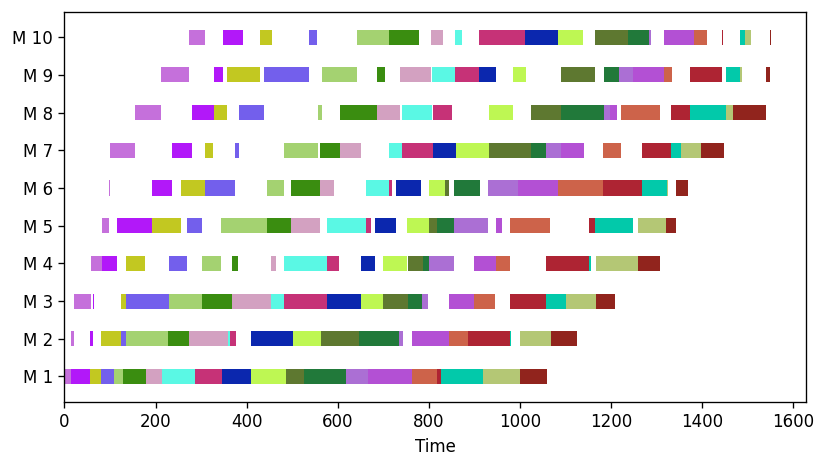

In [12]:
plot_gantt(
    res.sol.jobs,
    dpi=120,
    figsize=[7, 4],
    seed=42,
)

In [13]:
draw_gantt_gif(
    res.history,
    dpi=120,
    figsize=[7, 4],
    seed=42,
    label_cols=2,
    max_label=0,
    filename='pfssp-neh.gif',
    duration=600,
)

In [14]:
res.sol.bound

1550